In [41]:
import tensorflow as tf
import os
import shutil
import pathlib
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [5]:
!kaggle datasets download -d pavelbiz/eyes-rtte
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: maleeyes/2432.jpg       
  inflating: maleeyes/2433.jpg       
  inflating: maleeyes/2434.jpg       
  inflating: maleeyes/2435.jpg       
  inflating: maleeyes/2436.jpg       
  inflating: maleeyes/2437.jpg       
  inflating: maleeyes/2438.jpg       
  inflating: maleeyes/2439.jpg       
  inflating: maleeyes/244.jpg        
  inflating: maleeyes/2440.jpg       
  inflating: maleeyes/2441.jpg       
  inflating: maleeyes/2442.jpg       
  inflating: maleeyes/2443.jpg       
  inflating: maleeyes/2444.jpg       
  inflating: maleeyes/2445.jpg       
  inflating: maleeyes/2446.jpg       
  inflating: maleeyes/2448.jpg       
  inflating: maleeyes/2449.jpg       
  inflating: maleeyes/245.jpg        
  inflating: maleeyes/2450.jpg       
  inflating: maleeyes/2452.jpg       
  inflating: maleeyes/2453.jpg       
  inflating: maleeyes/2454.jpg       
  inflating: maleeyes/2455.jpg       
  inflating: maleeyes/2456.jpg       

In [6]:
parent_dir = '/content/gdrive/MyDrive/Kaggle/'
path = os.path.join(parent_dir, 'eyesdataset')
os.mkdir(path)

In [ ]:
shutil.move('/content/gdrive/MyDrive/Kaggle/femaleeyes', path)
shutil.move('/content/gdrive/MyDrive/Kaggle/maleeyes', path)

In [30]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
)

In [31]:
WIDTH = 64
HEIGHT = 64
BATCH_SIZE = 32

train_generator = training_datagen.flow_from_directory(
        path,
        target_size=(WIDTH, HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='rgb',
        subset='training')

validation_generator = training_datagen.flow_from_directory(
        path, 
        target_size=(WIDTH, HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='rgb',
        subset='validation')

Found 9221 images belonging to 2 classes.
Found 2304 images belonging to 2 classes.


In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation = "relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [49]:
save_model = 'model.h5'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-5, mode='min')

In [50]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    epochs=10,
    callbacks=[earlyStopping, modelCheckpoint, reducelr],
    verbose=1)

Epoch 1/10
288/288 [==============================] - 17s 59ms/step - loss: 0.4550 - accuracy: 0.7982 - val_loss: 1.8333 - val_accuracy: 0.5490

Epoch 00001: val_accuracy improved from -inf to 0.54905, saving model to model.h5
Epoch 2/10
288/288 [==============================] - 18s 62ms/step - loss: 0.3073 - accuracy: 0.8714 - val_loss: 0.4696 - val_accuracy: 0.7956

Epoch 00002: val_accuracy improved from 0.54905 to 0.79557, saving model to model.h5
Epoch 3/10
288/288 [==============================] - 17s 58ms/step - loss: 0.2576 - accuracy: 0.8930 - val_loss: 0.3082 - val_accuracy: 0.8746

Epoch 00003: val_accuracy improved from 0.79557 to 0.87457, saving model to model.h5
Epoch 4/10
288/288 [==============================] - 17s 58ms/step - loss: 0.2235 - accuracy: 0.9092 - val_loss: 0.2381 - val_accuracy: 0.9023

Epoch 00004: val_accuracy improved from 0.87457 to 0.90234, saving model to model.h5
Epoch 5/10
288/288 [==============================] - 18s 62ms/step - loss: 0.2006 

In [51]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Visualization Model Training
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epoch_number = range(len(acc))
    plt.figure(figsize=(6, 6), dpi=100)
    plt.subplot(2,1,1)
    plt.plot(epoch_number, acc, 'r', label='train acc')
    plt.plot(epoch_number, val_acc, 'b', label='val acc')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(epoch_number, loss, 'r', label='train loss')
    plt.plot(epoch_number, val_loss, 'b', label='val loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.show()

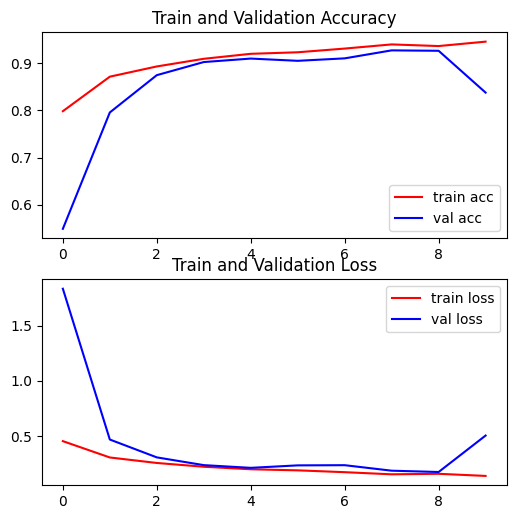

In [52]:
train_visualitation = plot_acc_loss(history)

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/tmp/model.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6o54bvvi/assets


INFO:tensorflow:Assets written to: /tmp/tmp6o54bvvi/assets


1572728